In [42]:
import pathlib
import sys
sys.path.append("..")
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

%load_ext autoreload
%autoreload 2

from utils import load_image_as_array, get_metadata_sample, plot_images, predict_image, plot_prediction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploring chest x-ray labels

In [3]:
data_dir = pathlib.Path("../data")
labels = pd.read_csv(data_dir / "labels.csv")
labels.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [4]:
print("##### LABELS #####")
labels["label"].value_counts()

##### LABELS #####


label
No Finding      980
Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: count, dtype: int64

# View particular chest x-ray label

In [5]:
IMG_HEIGHT, IMG_WIDTH = 256, 256

In [6]:
POS_LABEL = "Cardiomegaly"
NEG_LABEL = "No Finding"

pos_sample = get_metadata_sample(labels, POS_LABEL)
neg_sample = get_metadata_sample(labels, NEG_LABEL)

In [7]:
IMG_DIR = data_dir / "images"
pos_imgs = [load_image_as_array(IMG_DIR / img_file, IMG_HEIGHT, IMG_WIDTH) for img_file in pos_sample["filename"]]
neg_imgs = [load_image_as_array(IMG_DIR / img_file, IMG_HEIGHT, IMG_WIDTH) for img_file in neg_sample["filename"]]

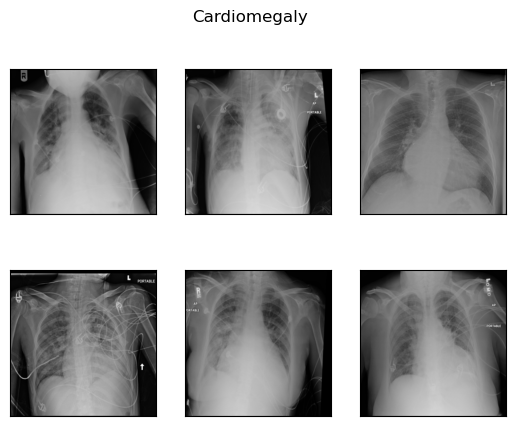

In [8]:
plot_images(pos_imgs, POS_LABEL)

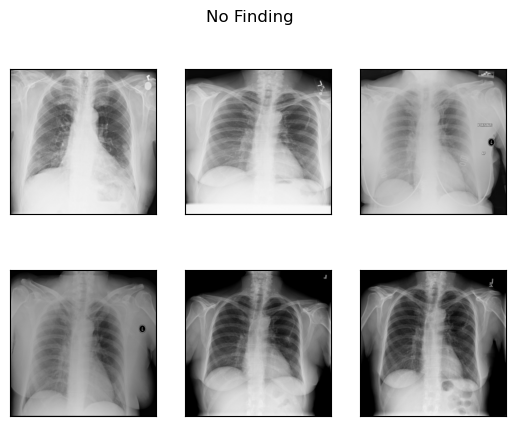

In [9]:
plot_images(neg_imgs, NEG_LABEL)

# Evaluate trained model

In [10]:
MODEL_PATH = pathlib.Path("..") / "model.keras"
model = tf.keras.models.load_model(MODEL_PATH)

2023-08-27 02:33:09.161191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-27 02:33:09.182562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-27 02:33:09.182704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [26]:
test_dir = data_dir / "test"
test_pos_dir, test_neg_dir = test_dir / "positive", test_dir / "negative"

## 1. Positive examples

In [55]:
test_results = []
for file in test_pos_dir.iterdir():
    logit, pred = predict_image(file, model, IMG_HEIGHT, IMG_WIDTH)
    test_results.append((file, "pos", pred, logit))

1/1 [==============================] - 0s 21ms/step


# 2. Negative examples

In [56]:
for file in test_neg_dir.iterdir():
    logit, pred = predict_image(file, model, IMG_HEIGHT, IMG_WIDTH)
    test_results.append((file, "neg", pred, logit))

1/1 [==============================] - 0s 21ms/step


In [57]:
# sort results by confidence
sorted_results = sorted(test_results, key=lambda x: x[3], reverse=True)

results_df = pd.DataFrame(sorted_results, columns=["filename", "label", "pred", "confidence"])
results_df.head(10)

,filename,label,pred,confidence
0,../data/test/positive/00014223_009.jpg,pos,pos,0.992852
1,../data/test/positive/00021409_001.jpg,pos,pos,0.971438
2,../data/test/positive/00018387_030.jpg,pos,pos,0.968377
3,../data/test/negative/00000167_000.jpg,neg,pos,0.964021
4,../data/test/positive/00003394_006.jpg,pos,pos,0.950061
5,../data/test/positive/00004533_014.jpg,pos,pos,0.934489
6,../data/test/positive/00004893_085.jpg,pos,pos,0.889779
7,../data/test/negative/00000100_001.jpg,neg,pos,0.866384
8,../data/test/positive/00020819_002.jpg,pos,pos,0.835243
9,../data/test/negative/00000468_045.jpg,neg,pos,0.825956


# 3. Plot some results

## 3a. True positive

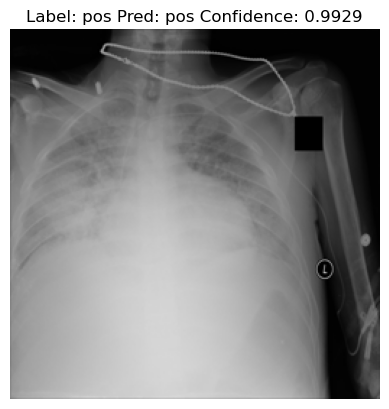

In [64]:
idx = 0
filename, label, pred, confidence = results_df.loc[idx]
plot_prediction(filename, label, pred, confidence, IMG_HEIGHT, IMG_WIDTH)

## 3b. True negative

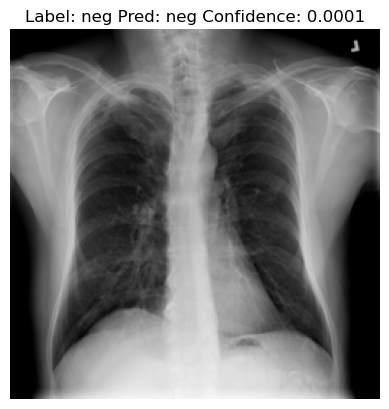

In [66]:
idx = len(results_df) - 1
filename, label, pred, confidence = results_df.loc[idx]
plot_prediction(filename, label, pred, confidence, IMG_HEIGHT, IMG_WIDTH)

# 3c. False positive

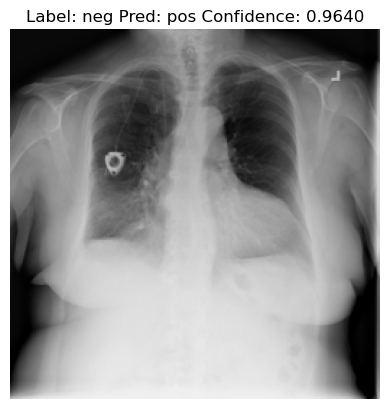

In [67]:
idx = 3
filename, label, pred, confidence = results_df.loc[idx]
plot_prediction(filename, label, pred, confidence, IMG_HEIGHT, IMG_WIDTH)

# 4. False negative

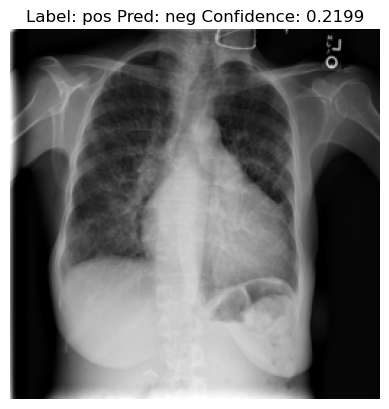

In [70]:
idx = 43
filename, label, pred, confidence = results_df.loc[idx]
plot_prediction(filename, label, pred, confidence, IMG_HEIGHT, IMG_WIDTH)